In [1]:
import pandas as pd

voy a usar yahoo finance para tener la informacion del sp500

In [2]:
import yfinance as yf

ahora voy a limpiar los datos para quedarme con lo que necesito

In [3]:
sp500 = yf.Ticker("^GSPC")

In [4]:
sp500 = sp500.history(period="max")

In [5]:
sp500 = sp500.loc["1990-01-01":].copy()

In [6]:
del sp500["Dividends"]

In [7]:
del sp500["Stock Splits"]

In [8]:
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000
...,...,...,...,...,...
2025-12-01 00:00:00-05:00,6812.299805,6843.649902,6799.939941,6812.629883,4549370000
2025-12-02 00:00:00-05:00,6830.959961,6851.549805,6806.709961,6829.370117,4582290000
2025-12-03 00:00:00-05:00,6815.290039,6862.419922,6810.430176,6849.720215,4736780000


In [9]:
sp500.index

DatetimeIndex(['1990-01-02 00:00:00-05:00', '1990-01-03 00:00:00-05:00',
               '1990-01-04 00:00:00-05:00', '1990-01-05 00:00:00-05:00',
               '1990-01-08 00:00:00-05:00', '1990-01-09 00:00:00-05:00',
               '1990-01-10 00:00:00-05:00', '1990-01-11 00:00:00-05:00',
               '1990-01-12 00:00:00-05:00', '1990-01-15 00:00:00-05:00',
               ...
               '2025-11-21 00:00:00-05:00', '2025-11-24 00:00:00-05:00',
               '2025-11-25 00:00:00-05:00', '2025-11-26 00:00:00-05:00',
               '2025-11-28 00:00:00-05:00', '2025-12-01 00:00:00-05:00',
               '2025-12-02 00:00:00-05:00', '2025-12-03 00:00:00-05:00',
               '2025-12-04 00:00:00-05:00', '2025-12-05 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=9050, freq=None)

<Axes: xlabel='Date'>

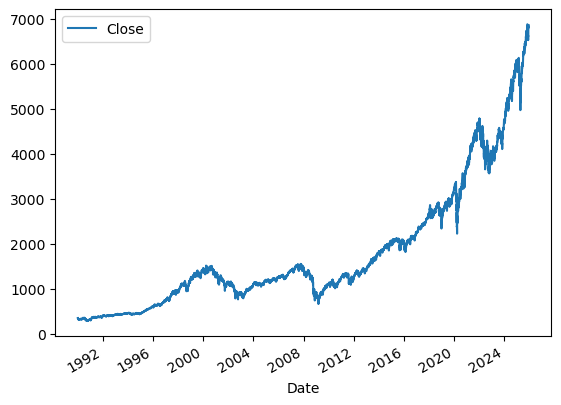

In [10]:
sp500.plot.line(y="Close", use_index=True)

quiero predecir el comportamiento del sp500 por lo que voy a hacer un modelo predictivo con machine learning

In [11]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [12]:
sp500["Target"] = (sp500["Tomorrow"]>sp500["Close"]).astype(int)

Target me va a mostrar 1 cuando el precio es mayor que el dia anterior y 0 cuando es menor, esto me ayudará en mi modelo

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [15]:
train = sp500.iloc[:-100]

In [16]:
test=sp500.iloc[-100:]

In [17]:
predictors = ["Close","Volume","Open","High","Low"]

In [18]:
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [19]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [20]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds= model.predict(test[predictors])
    preds=pd.Series(preds, index=test.index, name="Predictions")
    combined=pd.concat([test["Target"],preds],axis=1)
    return combined

In [21]:
def backtest(data,mode,predictors,start=2500,step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions =predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

lo que estoy haciendo es entrenar a mi modelo con informacion de todos los años

In [22]:
predictions = backtest(sp500, model,predictors)

In [23]:
predictions["Predictions"].value_counts()

Predictions
0    3880
1    2670
Name: count, dtype: int64

In [24]:
from sklearn.metrics import precision_score

In [25]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5307116104868914

mi modelo, por el momento, no es muy bueno
voy a darle mas informacion para mejorar la precisión

In [26]:
horizons = [2,5,60,250,1000]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column=f"Close_Ratio_{horizon}"
    sp500[ratio_column]=sp500["Close"]/rolling_averages["Close"]
    trend_column=f"Trend_{horizon}"
    sp500[trend_column]=sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors+= [ratio_column,trend_column]                                   

In [27]:
sp500=sp500.dropna()

In [28]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28 00:00:00-05:00,6822.520020,6850.859863,6819.750000,6849.089844,2558540000,6812.629883,0,1.002670,2.0,1.015110,5.0,1.022516,38.0,1.114970,143.0,1.380798,531.0
2025-12-01 00:00:00-05:00,6812.299805,6843.649902,6799.939941,6812.629883,4549370000,6829.370117,1,0.997331,1.0,1.003471,4.0,1.016236,38.0,1.108472,142.0,1.372833,530.0
2025-12-02 00:00:00-05:00,6830.959961,6851.549805,6806.709961,6829.370117,4582290000,6849.720215,1,1.001227,1.0,1.002268,4.0,1.017887,38.0,1.110630,142.0,1.375612,530.0


In [29]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=1)

In [30]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds= model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6]=1
    preds[preds<.6]=0
    preds=pd.Series(preds, index=test.index, name="Predictions")
    combined=pd.concat([test["Target"],preds],axis=1)
    return combined

quiero estar seguro que el precio va a subir, por lo que mi modelo lo que hace es:
mira las tendencias del sp500 y solo decide invertir cuando este con un 60% de confianza o mas de que el mercado va a subir

In [31]:
predictions=backtest(sp500, model, new_predictors)

In [32]:
predictions["Predictions"].value_counts()

Predictions
0.0    4740
1.0     809
Name: count, dtype: int64

In [33]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5710754017305315